In [1]:
import torch

import os
# os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [2]:
def _get_cuda_autotune_config():
    configs = []
    for num_warps, num_stages in [
        (4, 2),
        (4, 3),
        (4, 4),
        (8, 2),
        (8, 4),
    ]:
        for BLOCK_SIZE_M in [128]:
            for BLOCK_SIZE_N in [128]:
                for BLOCK_SIZE_K in [32, 64]:
                    configs.append(
                        triton.Config(
                            {
                                "GROUP_SIZE_M" : 8,
                                "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                            }, 
                            num_stages=num_stages, 
                            num_warps=num_warps
                        ),
                    )                        
    return configs
    return [triton.Config(
                                {
                                    "GROUP_SIZE_M" : 8,
                                    "BLOCK_SIZE_M" : 64,
                                    "BLOCK_SIZE_N" : 32,
                                    "BLOCK_SIZE_K" : 64,
                                },
                                num_stages=2, 
                                num_warps=8
                            )]
# GROUP_SIZE_M: 8, BLOCK_SIZE_M: 64, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 64, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None

In [3]:
@triton.autotune(
    configs=_get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_int8(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    accumulator_dtype = tl.int32
    
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # -----------------------------------------------------------
    # Add some integer bound assumptions.
    # This helps to guide integer analysis in the backend to optimize
    # load/store offset address calculation
    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0)
        # We accumulate along the K dimension.

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    c = accumulator #.to(tl.int32)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


@triton.autotune(
    configs=_get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_float8(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    accumulator_dtype = tl.float32
    
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # -----------------------------------------------------------
    # Add some integer bound assumptions.
    # This helps to guide integer analysis in the backend to optimize
    # load/store offset address calculation
    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    c = accumulator

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)



def triton_matmul_8bit(a, b, mode):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape
    

    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    
    if mode == "int8":
        c = torch.empty((M, N), device=a.device, dtype=torch.int32)
        matmul_kernel_int8[grid](
            a, b, c,  #
            M, N, K,  #
            a.stride(0), a.stride(1),  #
            b.stride(0), b.stride(1),  #
            c.stride(0), c.stride(1),  #
        )

    elif mode == "float8":
        c = torch.empty((M, N), device=a.device, dtype=torch.float16)
        matmul_kernel_float8[grid](
            a, b, c,  #
            M, N, K,  #
            a.stride(0), a.stride(1),  #
            b.stride(0), b.stride(1),  #
            c.stride(0), c.stride(1),  #
        )

    return c


In [4]:
# torch.manual_seed(0)

# M, N, K = 3 * (512,)

# y_int8 = torch.randint(-128, 128, (M, K), dtype=torch.int8, device="cuda")
# x_int8 = torch.randint(-128, 128, (K, N), dtype=torch.int8, device="cuda")

# o_int8 = triton_matmul_8bit(y_int8, x_int8, mode="int8")

# y_fp8 = torch.randn((M, K), device="cuda").to(torch.float8_e5m2)
# x_fp8 = torch.randn((K, N), device="cuda").to(torch.float8_e5m2)

# o_fp8 = triton_matmul_8bit(y_fp8, x_fp8, mode="float8")

# o_fp16 = torch.matmul(y_fp8.to(torch.float16), x_fp8.to(torch.float16))
# assert torch.all(torch.isclose(o_fp8.to(torch.float16), o_fp16))

In [5]:
# print(matmul_kernel_float8.best_config)

### Square matrices

matmul-performance:
        K       M       N  torch_fp16  triton_fp8  triton_fp8_T  triton_int8  triton_int8_T
0  2048.0  2048.0  2048.0   95.173005  155.750195    171.196087   205.304373     247.748463
1  4096.0  4096.0  4096.0   89.076713  177.093794    165.784049   240.654865     328.965026
2  8192.0  8192.0  8192.0   88.206838  160.657493    156.370406   218.991327     305.375108


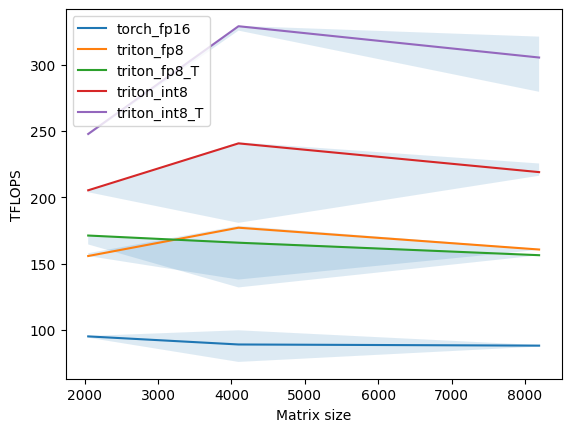

In [ ]:
sizes = [2048, 4096, 8192]

configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["K", "M", "N"],
        x_vals=[(size, size, size) for size in sizes],
        # x_vals=[(size, size, size) for size in sizes],
        line_arg="provider",
        line_vals=[
            "torch_fp16",
            # "torch_fp32",
            # "triton_fp8",
            "triton_fp8_T", 
            # "triton_int8",
            "triton_int8_T",
        ],
        line_names=[
            "torch_fp16",
            # "torch_fp32",
            # "triton_fp8", 
            "triton_fp8_T", 
            # "triton_int8",
            "triton_int8_T",
        ],
        ylabel="TFLOPS",
        xlabel="Matrix size",
        plot_name="matmul-performance",
        args={},
    ))

torch.set_float32_matmul_precision("high")

@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    y_fp8 = torch.randn((M, K), device="cuda").to(torch.float8_e5m2)
    x_fp8 = torch.randn((K, N), device="cuda").to(torch.float8_e5m2)
    x_fp8_T = x_fp8.T.contiguous().T

    y_int8 = torch.randint(-128, 128, (M, K), dtype=torch.int8, device="cuda")
    x_int8 = torch.randint(-128, 128, (K, N), dtype=torch.int8, device="cuda")
    x_int8_T = x_int8.T.contiguous().T

    y_fp16 = y_fp8.to(torch.float16).contiguous()
    x_fp16 = x_fp8.to(torch.float16).contiguous()

    y_fp32 = y_fp8.to(torch.float32).contiguous()
    x_fp32 = x_fp8.to(torch.float32).contiguous()


    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y_fp16, x_fp16), quantiles=quantiles)
    if provider == "torch_fp32":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y_fp32, x_fp32), quantiles=quantiles)
    if provider == "triton_fp8":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_8bit(y_fp8, x_fp8, mode="float8"), quantiles=quantiles)
    if provider == "triton_fp8_T":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_8bit(y_fp8, x_fp8_T, mode="float8"), quantiles=quantiles)
    if provider == "triton_int8":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_8bit(y_int8, x_int8, mode="int8"), quantiles=quantiles)
    if provider == "triton_int8_T":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_8bit(y_int8, x_int8_T, mode="int8"), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=False, print_data=True)

In [7]:
raise

RuntimeError: No active exception to reraise

### Small activations

matmul-performance:
         M       N       K  torch_fp16  triton_fp8  triton_int8
0      1.0  4096.0  4096.0    0.391406    0.456896     0.496485
1      4.0  4096.0  4096.0    2.534323    2.184533     2.621440
2     16.0  4096.0  4096.0    9.658731    9.039448    10.485760
3     64.0  4096.0  4096.0   38.065153   35.117145    43.690665
4    256.0  4096.0  4096.0   84.122673  140.468580   162.098702
5   1024.0  4096.0  4096.0   95.767201  161.537808   218.284576
6   4096.0  4096.0  4096.0   88.884992  157.532540   239.520798
7  16384.0  4096.0  4096.0   86.745989  166.676715   228.552968


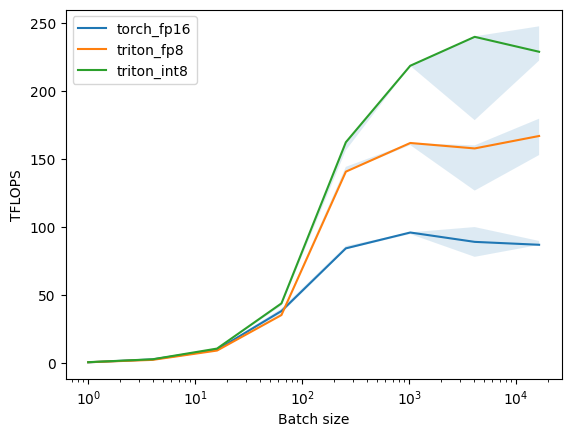

In [ ]:
configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["M", "N", "K"],
        x_vals=[(BS, 4096, 4096) for BS in [1, 4, 16, 64, 256, 1024, 4096, 4*4096]],
        line_arg="provider",
        line_vals=[
            "torch_fp16", 
            "triton_fp8", 
            "triton_int8"
        ],
        line_names=[
            "torch_fp16", 
            "triton_fp8", 
            "triton_int8"
        ],
        ylabel="TFLOPS",
        xlabel="Batch size",
        plot_name="matmul-performance",
        args={},
        x_log=True,
    ))


@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    y_fp8 = torch.randn((M, K), device="cuda").to(torch.float8_e5m2)
    x_fp8 = torch.randn((K, N), device="cuda").to(torch.float8_e5m2)

    y_int8 = torch.randint(-128, 128, (M, K), dtype=torch.int8, device="cuda")
    x_int8 = torch.randint(-128, 128, (K, N), dtype=torch.int8, device="cuda")

    y_fp16 = y_fp8.to(torch.float16)
    x_fp16 = x_fp8.to(torch.float16)

    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y_fp16, x_fp16), quantiles=quantiles)
    if provider == "triton_fp8":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_8bit(y_fp8, x_fp8, mode="float8"), quantiles=quantiles)
    if provider == "triton_int8":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_8bit(y_int8, x_int8, mode="int8"), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=False, print_data=True)